# Opdracht classificatie 1 - logistic regression

Logistische regressie is een bijzonder populaire classificatietechniek. Enerzijds door zijn eenvoud en relatief lage eisen die het stelt in termen van rekenkracht. In veel gevallen is de performantie qua accuracy vergelijkbaar (en soms beter) dan gecompliceerdere algoritmes zoals de support vector machines.
Daarnaast heeft logistische regressie het voordeel dat het getrainde model een voorspelling doet in termen van de kans dat de input tot een bepaalde klasse behoort. Uit deze kans kan je afleiden hoe overtuigd het model is van de gemaakte voorspelling.

Het is de bedoeling om via enkele classificatieopdrachten inzicht te verkrijgen in:
- Correct trainen en het uitvoeren van hyperparameter tuning bij logistische regressie.
- Classificaties kunnen uitvoeren via logistische regressie.
- Feature engineering uitvoeren.
- Interpreteren van de verschillende performance metrics: accuracy, recall, precision, f1-score, ROC.
- Kunnen omgaan met niet-gebalanceerde data en het kunnen regelen tussen het aantal false positives en false negatives. 
- Weten wanneer je te maken hebt met overfitting en underfitting en de juiste bijstellingen kunnen doen.


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

## Opdracht 1: Sensors data


Het bestand sensors_data_test is een tijdelijke bestand om onze sensorsdata te simuleren
Train nu een logic regression model dat op basis van de features een zo goed mogelijke predictie kan doenvan de afstand waar er eenfles is genomen.

### Kolom toevoegen


### Inlezen van de dataset en vooranalyse

In [2]:
# inlezen van de dataset
dataset = pd.read_csv('Sensor_data.csv')
dataset.head()

,PartitionKey,RowKey,Timestamp,RackRow,RackRow@type,Label,Label@type,WeightPre,WeightPre@type,WeightPost,...,DistAvgH,DistAvgH@type,DistMinL,DistMinL@type,DistMaxL,DistMaxL@type,DistAvgL,DistAvgL@type,DistTime,DistTime@type
0,F0:08:D1:C8:A7:34,03674838-7a7d-4f65-a8ff-11315e0d3d10,2022-05-28T13:58:26.3120062Z,2,Int32,21,Int32,0,Int32,0,...,31,Int32,27,Int32,36,Int32,31,Int32,3358,Int32
1,F0:08:D1:C8:A7:34,0376173d-7059-4211-b4a1-7c168b32ce98,2022-05-28T14:26:33.9141792Z,2,Int32,20,Int32,0,Int32,0,...,33,Int32,31,Int32,42,Int32,35,Int32,1870,Int32
2,F0:08:D1:C8:A7:34,0628a786-28da-4c9f-97fc-6ee240e75782,2022-05-28T14:24:57.4637252Z,2,Int32,13,Int32,0,Int32,0,...,40,Int32,37,Int32,43,Int32,40,Int32,2063,Int32
3,F0:08:D1:C8:A7:34,062a202a-19cc-4c61-814f-7458a33e04d0,2022-05-28T14:26:42.7918921Z,2,Int32,21,Int32,0,Int32,0,...,26,Int32,24,Int32,30,Int32,26,Int32,1686,Int32
4,F0:08:D1:C8:A7:34,06e05b50-bcbf-4fad-a713-c19975ef4b42,2022-05-25T13:16:47.9637282Z,2,Int32,3,Int32,0,Int32,0,...,28,Int32,27,Int32,29,Int32,28,Int32,207,Int32


Controleer of de dataset inconsistenties of foute waarden bevat. Gebruik listwise deletion. Dit betekent dat je alle gegevens van een persoon uit de dataset verwijdert van zodra er 1 feature foutief is of ontbreekt.

In [3]:

# verwijder kollomen die niet relevant zijn met model (id's,types)
dataset.drop(['PartitionKey','Timestamp','RackRow','RowKey'],axis=1,inplace=True)
dataset.drop('RackRow@type',axis=1,inplace=True)
# dataset.drop('Label',axis=1,inplace=True)
dataset.drop('Label@type',axis=1,inplace=True)

# verwijder kollomen weight 
dataset.drop(['WeightPre','WeightPre@type','WeightPost','WeightPost@type', 'WeightDiff','WeightDiff@type'],axis=1,inplace=True)


#verwijder kollomen distance
dataset.drop(['DistMinH@type','DistMaxH@type','DistAvgH@type','DistMinL@type', 'DistMaxL@type','DistAvgL@type', 'DistTime@type'],axis=1,inplace=True)


#one hot encoding
# dataset = pd.concat([dataset,pd.get_dummies(dataset['RowKey'], prefix='RowKey')],axis=1)
# dataset.drop(['RowKey'],axis=1, inplace=True)



dataset.head(1000)


,Label,DistMinH,DistMaxH,DistAvgH,DistMinL,DistMaxL,DistAvgL,DistTime
0,21,27,36,31,27,36,31,3358
1,20,31,37,33,31,42,35,1870
2,13,38,43,40,37,43,40,2063
3,21,24,30,26,24,30,26,1686
4,3,27,29,28,27,29,28,207
...,...,...,...,...,...,...,...,...
145,16,16,17,16,16,17,16,2422
146,22,23,23,23,23,23,23,22
147,9,28,30,29,28,30,29,1502
148,5,13,16,14,13,16,14,2069


In [4]:
#Toevoegen van 'leftside_crate' kolom op basis van labels (1-3,7-9,13-15,19-21)
dataset.insert(0,'side_crate', dataset['Label'])
#dataset.insert(0,'rightside_crate', dataset['Label'])

# leftside_crate waarden links is 0, rechts is 1
dataset['side_crate'].values[dataset['Label'] <=24] = 1
dataset['side_crate'].values[dataset['Label'] <=21] = 0
dataset['side_crate'].values[dataset['Label'] <= 18] = 1
dataset['side_crate'].values[dataset['Label'] <= 15] = 0
dataset['side_crate'].values[dataset['Label'] <= 12] = 1
dataset['side_crate'].values[dataset['Label'] <= 9] = 0
dataset['side_crate'].values[dataset['Label'] <= 6] = 1
dataset['side_crate'].values[dataset['Label'] <= 3] = 0

#originele Label feature verwijderen
dataset.drop('Label',axis=1,inplace=True)



dataset.head(10)

,side_crate,DistMinH,DistMaxH,DistAvgH,DistMinL,DistMaxL,DistAvgL,DistTime
0,0,27,36,31,27,36,31,3358
1,0,31,37,33,31,42,35,1870
2,0,38,43,40,37,43,40,2063
3,0,24,30,26,24,30,26,1686
4,0,27,29,28,27,29,28,207
5,1,4,8,4,4,8,4,2406
6,1,21,24,21,21,26,23,2601
7,0,33,43,39,33,43,39,2809
8,1,22,24,23,23,24,23,1877
9,1,15,17,15,15,17,15,1680


In [5]:
import pickle

In [6]:
with open('finalized_model.pkl','rb' ) as filename:
    pickled_model = pickle.load(filename)

### Preprocessing en opsplitsen van de dataset

Splits de dataset in **features en targets**.

In [9]:
# Opsplitsen in features en targets
y = dataset['side_crate'].values
X = dataset.drop(['side_crate'], axis = 1).values

print(X.shape)
print(y.shape)


#1 lijst met 150 waarden, 7 features

(150, 7)
(150,)


Creëer een **trainingset en een testset**. Zorg dat er 100 patiënten in de testset steken. 

In [10]:
# Opsplitsen/opdelen in training set en test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

#training set
print(X_train.shape)

#test set
print(X_test.shape)



(100, 7)
(50, 7)


**Schaal de dataset**. Zorg er dus voor dat de features op een gelijke schaalverdeling staan. Voor het scalen kan gebruik gemaakt worden van de *preprocessing.StandardScaler()*. Meer info over het gebruik ervan is te vinden op http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [11]:
# Normaliseren / scaling van de training set en de test set
scaler = StandardScaler() #scalen
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
X_train[1]

array([ 0.1949807 ,  0.62311067,  0.5040962 ,  0.1842191 ,  0.59072547,
        0.49387276, -0.78191475])

### Trainen van een logistic regression classifier en testen van het bekomen model

Train een logistic regression classifier op de training data. Kies C=1 als startwaarde. Mocht de dataset niet gebalanceerd zijn (de ene klasse komt frequenter voor dan de andere klasse) dan kan je bij de creatie van het logistic regression model de parameter class_weight='balanced' meegeven. Meer info: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Test het getrainde model op de test set. Bepaal hierbij de confusion matrix, de accuracy en het classification report. Wat zijn de bevindingen? Probeer ook verschillende solvers uit. Bepaal ook telkens de ROC en formuleer conclusies.

Probeer de performantie van de classifier te verhogen door de parameter C te veranderen.

Evalueer de modellen telkens via de confusion matrix, classification report en indien mogelijk via de ROC-curve. Bespreek de resultaten.

In [13]:
# Train een logistic regression classifier

logreg = linear_model.LogisticRegression(C=1e3, solver='lbfgs', max_iter=10000 ) # C= Inverse of regularization strength;
                                                # must be a positive float. Like in support vector machines,



    # smaller values specify stronger regularization.
logreg.fit(X, y)

print('coefficiënten: ',logreg.coef_)
print('intercept:',logreg.intercept_)

coefficiënten:  [[-2.60325554e-01 -1.15050882e-01 -1.74419716e+00  7.70613163e-01
   2.21843922e-01  7.42297546e-01 -2.79731729e-04]]
intercept: [9.37819124]


In [14]:
#parameters/andere features meegeven
side_crate = np.array([[22,24,23,23,24,23,1877]])
pickled_model.predict(side_crate)
print(logreg.predict(side_crate))

print(logreg.predict_proba(np.array([22,24,23,23,24,23,1877]).reshape(1,-1)))

[1]
[[0.40868186 0.59131814]]


In [15]:
# testen van de logistic regression classifier

y_pred = logreg.predict(X_test)

print(classification_report(y_test,y_pred))

print(accuracy_score(y_test,y_pred)*100)


print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.42      1.00      0.59        21

    accuracy                           0.42        50
   macro avg       0.21      0.50      0.30        50
weighted avg       0.18      0.42      0.25        50

42.0
[[ 0 29]
 [ 0 21]]


C:\Users\domin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\domin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\domin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

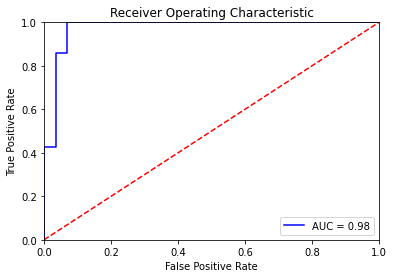

In [16]:
# ROC

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = logreg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [17]:
#probability prediciton van ROC
print(probs)

[[9.90433761e-05 9.99900957e-01]
 [5.18333296e-05 9.99948167e-01]
 [1.75756532e-04 9.99824243e-01]
 [1.62700867e-04 9.99837299e-01]
 [1.87116634e-04 9.99812883e-01]
 [7.56556615e-05 9.99924344e-01]
 [4.81582534e-05 9.99951842e-01]
 [8.36000392e-05 9.99916400e-01]
 [1.26771971e-04 9.99873228e-01]
 [1.61310298e-04 9.99838690e-01]
 [1.76927761e-04 9.99823072e-01]
 [6.14529364e-05 9.99938547e-01]
 [1.53317434e-04 9.99846683e-01]
 [1.69740485e-04 9.99830260e-01]
 [1.24632175e-04 9.99875368e-01]
 [5.84241351e-05 9.99941576e-01]
 [1.34821016e-04 9.99865179e-01]
 [1.20109973e-04 9.99879890e-01]
 [1.39836087e-04 9.99860164e-01]
 [4.42601708e-05 9.99955740e-01]
 [8.02679689e-05 9.99919732e-01]
 [4.77247341e-05 9.99952275e-01]
 [1.37323117e-04 9.99862677e-01]
 [8.50530505e-05 9.99914947e-01]
 [1.25910589e-04 9.99874089e-01]
 [6.14346351e-05 9.99938565e-01]
 [9.81109772e-05 9.99901889e-01]
 [1.20680377e-04 9.99879320e-01]
 [7.76287549e-05 9.99922371e-01]
 [1.14236189e-04 9.99885764e-01]
 [1.394067

### Feature engineering
Creeër hogere orde features door gebruik te maken van *preprocessing.PolynomialFeatures*. Meer info is te vinden op http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

Deze functie zal automatische hogere orde features aanmaken door het combineren van de aanwezige features. Heb je bijvoorbeeld drie features, zijnde A, B en C dan worden bij de keuze van een derde orde PolynomialFeatures volgende nieuwe features bijgemaakt:
$A^3, B^3,C^3,A^2B,A^2C,AB^2, B^2C,...$

Experimenteer met verschillende ordes en gebruik de regularisatieparameter C om de performantie te verhogen. Voor indien nodig ook regularisatie uit via een L1 of L2 penalty.

**Opgepast**: het kiezen van een te hoge orde zorgt voor een exponentiële toename aan features waardoor de logistic regression classifier niet meer binnen aanvaardbare tijd getraind kan worden. Advies is om niet hoger te gaan dan 4de orde.

In [18]:
# Toevoegen van extra features
# Modeloptimalisatie en Hyperparameter tuning
# Automatisch toevoegen van hogere orde features

from sklearn.preprocessing import PolynomialFeatures


# Aanmaken van de hogere orde features
graad = 3

poly = PolynomialFeatures(graad)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)
print('dimensie van X_train_poly: ',X_train_poly.shape)
print('dimensie van X_test_poly: ',X_test_poly.shape)

#scalen (optioneel?)
scaler_poly = StandardScaler()
scaler_poly.fit(X_train_poly)

X_train_poly = scaler_poly.transform(X_train_poly)
X_test_poly = scaler_poly.transform(X_test_poly)


# met L2 regularisatie via Ridge regression
lregmodel_poly = Ridge(alpha=20,tol=0.0001,fit_intercept=True)
lregmodel_poly.fit(X_train_poly,y_train)

print('R2 score op test set via L2: ',lregmodel_poly.score(X_test_poly,y_test))
# R2 -score via L2 op de trainingset
print('R2 score op training set via L2: ',lregmodel_poly.score(X_train_poly,y_train))


# met L1 regularisatie via Lasso regression
lregmodel_poly = Lasso(alpha=0.001,tol=0.001,fit_intercept=True)
lregmodel_poly.fit(X_train_poly,y_train)      
  
      
print('R2 score op test set via L1: ',lregmodel_poly.score(X_test_poly,y_test))
  
# R2 -score via L1 op de trainingset
print('R2 score op training set via L1: ',lregmodel_poly.score(X_train_poly,y_train))  


dimensie van X_train_poly:  (100, 120)
dimensie van X_test_poly:  (50, 120)
R2 score op test set via L2:  0.7307699791821289
R2 score op training set via L2:  0.8276500129993295
R2 score op test set via L1:  0.6570097216138092
R2 score op training set via L1:  0.8666775695010323


C:\Users\domin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.570e-02, tolerance: 2.475e-02
  model = cd_fast.enet_coordinate_descent(


In [19]:
#R2 trainingsscore 0.83 en 0.88 (graad 3) 

Wat zijn de bevindingen? Formuleer een conclusie. Bespreek hierin de performantie van de getrainde modellen. Wat is de invloed van de parameter C en van het aantal features? Heb je te maken gehad met underfitting en overfitting en hoe heb je dit bepaald? Welke accuracy werd bekomen en hoe zit het met de Recall en Precision? Is de grootte van de trainingset voldoende?

Antwoord: Er was een schommeling van 0.02 bij accuracy afhankelijk van hoe ik de C-waarde wijzigde (C1e5->C1e1), mijn accuracy is 80.0, ook de recall en precision wijzigde mee met de C-waarde (schommeling van 0.1)

Bij het toevoegen van hogere orde features heb ik de R2 score bij de trainingsets op 0.96 en 0.99.

### Voorspel aan de hand van het getrainde model

Voorspel of linker kant van krat of niet. Geef ook de zekerheid van het model weer (kansen dat de fles/hand tot een bepaalde klasse behoort).



(leftside_crate) Label	DistMinH	DistMaxH	DistAvgH	DistMinL	DistMaxL	DistAvgL	DistTime

1	21	27	36	31	27	36	31	3358			


In [20]:
# Voorspelling van de DistAvgL.
side_crate = np.array([[21,27,36,31,27,36,31,3358]])

#scaling
scaler.transform(side_crate)

print(logreg.predict(side_crate))

print(logreg.predict_proba(np.array([21,27,36,31,27,36,31,3358]).reshape(1,-1)))






ValueError: X has 8 features, but StandardScaler is expecting 7 features as input.

In [ ]:
import pickle

In [ ]:
filename = 'finalized_model.pkl'
pickle.dump(logreg, open(filename, 'wb'))

In [ ]:
# pickle.load(logreg, open(filename, 'rb'))
# pickled_model = pickle.load(filename)

with open('finalized_model.pkl','rb' ) as filename:
    pickled_model = pickle.load(filename)

In [ ]:
#parameters/andere features meegeven
side_crate = np.array([[21,27,36,31,27,36,21,3358]])
pickled_model.predict(side_crate)

Standaard zal het model een sample toewijzen aan klasse 1 van zodra de probiliteit boven de threshold van 50% uisteekt. 
Men wil echter de kans op false negatives drastisch verminderen door het aanpassen van de threshold. Welke threshold moet men instellen om ervoor te zorgen dat het model op de test set geen false negatives meer voorspelt en toch nog een zo hoog mogelijke accuraatheid heeft?
Stel het aantal false negatives in functie van de threshold grafisch voor. Bespreek de resultaten.

In [ ]:
# reduceren van het aantal false negatives door de threshold aan te passen
#threshold verlagen!
# reduceren van het aantal false negatives door de threshold aan te passen

threshold = 0.21

probs = logreg.predict_proba(X_test)

preds = probs[:,1]

preds2 = []



for prediction in preds:

    if  prediction >= threshold:

        preds2.append(1)

    else:

        preds2.append(0)



print("Origional:")

print(classification_report(y_test,y_pred))

print(confusion_matrix(y_test,y_pred))

print(accuracy_score(y_test,y_pred)*100)



print("Lowered threshold:")

print(classification_report(y_test, preds2))

print(confusion_matrix(y_test,preds2))

print(accuracy_score(y_test,preds2)*100)


## Opdracht 2. Penguins


De dataset `penguins.csv` bevat data van verschillende soorten pinguïns. Deze dataset is origineel bedoeld om te kijken of het mogelijk is om te voorspellen tot welke soort een pinguïns behoort aan de hand van de andere variabelen.

<img src='penguins.jpg'>

<br />

| Variable | Beschrijving |
| --- | --- | 
|studyName 	|De studie waar de data van de penguin oorspronkelijk vandaan komt. |
|Sample Number|	Een unieke ID die iedere penguin die in het onderzoek voorkomt krijgt.
|Species |	 De soorten penguins die voorkomen in de dataset.|
|Island | Het eiland waar de penguin geobserveerd werd.|
|Clutch Completion | Of er minstens 1 eitje uit het nest uitgekomen is.|
|Culmen Length (mm) |	De lengte van de snavel in millimeter. |
|Culmen Depth (mm) | De diepte van de snavel in millimeter. |
|Flipper Length (mm)  	| De lengte van de vin in millimeter. |
|Body Mass (g) | Het gewicht van de penguin in gram. |
|Sex | Het geslacht (binair: 'FEMALE' - vrouw or 'MALE' - man)|
|Comments | Specifieke commentaar die bij een bepaalde penguin hoort.|

<br />   
lees de dataset in en toon de eerste 7 rijen.  <br />   
De kolom comments heeft amper data, deze kolom mag uit de dataset verwijdert worden.  <br />   
Gebruik listwise deletion bij de overige ontbrekende waarden. Is de dataset gebalanceerd? Maw, zijn er evenveel penguins per soort?  <br />   
Bouw een logistic regression model dat zo accuraat mogelijk de penguinsoort kan bepalen. Hierbij pas je alle overige preprocessing stappen toe die je nodig acht. Het is ook toegestaann om features bij te maken of weg te laten.
<br />   
Schrijf jouw conclusies op met betrekking tot het finaal bekomen model.


In [ ]:
dataset = pd.read_csv('TestData2.csv')
print('Dimensie van de dataset:',dataset.shape)
dataset.head(7)

In [ ]:
# uitwerking van de opdracht: 

#comments kolom verwijderen
# verwijder kollomen die niet relevant zijn met model (id's,types)
dataset.drop(['PartitionKey','RowKey','Timestamp','RackRow'],axis=1,inplace=True)
dataset.drop('RackRow@type',axis=1,inplace=True)
dataset.drop('Label',axis=1,inplace=True)
dataset.drop('Label@type',axis=1,inplace=True)

# verwijder kollomen weight 
dataset.drop(['WeightPre','WeightPre@type','WeightPost','WeightPost@type', 'WeightDiff','WeightDiff@type'],axis=1,inplace=True)


#verwijder kollomen distance
dataset.drop(['DistMinH@type','DistMaxH@type','DistAvgH@type','DistMinL@type', 'DistMaxL@type','DistAvgL@type', 'DistTime@type'],axis=1,inplace=True)


#one hot encoding
# dataset = pd.concat([dataset,pd.get_dummies(dataset['RackRow'], prefix='RackRow')],axis=1)
# dataset.drop(['RackRow'],axis=1, inplace=True)





dataset.head(7)

In [ ]:
# Toevoegen van 'kant_krat_links' kolom op basis van DistAvgL
# dataset.insert(0,'kant_krat_links', dataset['DistAvgL'])

# #DistAvgL waarden

# dataset['kant_krat_links'].values[dataset['DistAvgL'] < 20] = 0
# dataset['kant_krat_links'].values[dataset['DistAvgL'] >= 20] = 1

dataset.head(10)

In [ ]:
# gebalanceerdheid controleren
sns.countplot(data=dataset, x="DistAvgL")
plt.title('DistAvgL')

In [ ]:
# Opsporen van ontbrekende waarden

missing_values_count = dataset.isnull().sum()
print(missing_values_count)
msno.matrix(dataset)

In [ ]:
# Lineaire correlatie tussen de features - heatmap

dataset.corr()

# Visualiseer de onderlinge correlatiecoëfficiënten
f, ax = plt.subplots(figsize=(10, 8))
corr = dataset.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax,annot=True)

In [ ]:
# Opsplitsen in features en targets
y = dataset['DistAvgL'].values
X = dataset.drop(['DistAvgL'], axis = 1).values

print(X.shape)
print(y.shape)



#1 lijst met 333 waarden, 10 features

In [ ]:
# Opsplitsen/opdelen in training set en test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90, random_state=0)

#training set
print(X_train.shape)

#test set
print(X_test.shape)

In [ ]:
# Normaliseren / scaling van de training set en de test set

# Om conversion warning te vermijden:
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')


scaler = StandardScaler() #scalen
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train[1]

In [ ]:
# Train een logistic regression classifier

logreg = linear_model.LogisticRegression(C=1e4, solver='lbfgs') # C= Inverse of regularization strength;
                                                # must be a positive float. Like in support vector machines,
                                                # smaller values specify stronger regularization.
logreg.fit(X, y)

print('coefficiënten: ',logreg.coef_)
print('intercept:',logreg.intercept_)

In [ ]:
# testen van de logistic regression classifier

y_pred = logreg.predict(X_test)

print(classification_report(y_test,y_pred))

print(accuracy_score(y_test,y_pred)*100)

print(confusion_matrix(y_test,y_pred))

In [ ]:
# ROC

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = logreg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#probability prediciton van ROC
print(probs)

In [ ]:
# Toevoegen van extra features
# Modeloptimalisatie en Hyperparameter tuning
# Automatisch toevoegen van hogere orde features

from sklearn.preprocessing import PolynomialFeatures


# Aanmaken van de hogere orde features
graad = 2

poly = PolynomialFeatures(graad)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)
print('dimensie van X_train_poly: ',X_train_poly.shape)
print('dimensie van X_test_poly: ',X_test_poly.shape)

#scalen (optioneel?)
scaler_poly = StandardScaler()
scaler_poly.fit(X_train_poly)

X_train_poly = scaler_poly.transform(X_train_poly)
X_test_poly = scaler_poly.transform(X_test_poly)


# met L2 regularisatie via Ridge regression
lregmodel_poly = Ridge(alpha=20,tol=0.01,fit_intercept=True)
lregmodel_poly.fit(X_train_poly,y_train)

print('R2 score op test set via L2: ',lregmodel_poly.score(X_test_poly,y_test))
# R2 -score via L2 op de trainingset
print('R2 score op training set via L2: ',lregmodel_poly.score(X_train_poly,y_train))


# met L1 regularisatie via Lasso regression
lregmodel_poly = Lasso(alpha=0.1,tol=0.01,fit_intercept=True)
lregmodel_poly.fit(X_train_poly,y_train)      
  
      
print('R2 score op test set via L1: ',lregmodel_poly.score(X_test_poly,y_test))
  
# R2 -score via L1 op de trainingset
print('R2 score op training set via L1: ',lregmodel_poly.score(X_train_poly,y_train)) 

In [ ]:
#R2- score op trainingsets: 0.89 en 0.75 graad 4

## Opdracht 3.  Star Wars

Train een logistic regression classifier aan de hand van de dataset 'StarWars.csv') om te voorspellen of iemand al dan niet een Star Wars fan is.
Gebruik one-hot encondig waar nodig. Zorg ervoor dat de test set uit minstens 200 samples bestaat.
Evalueer de getrainde classifier via de geziene metrics en bespreek de resultaten.

In [ ]:
dataset = pd.read_csv('StarWars.csv')
dataset.head(35)

# we merken op dat rij 19 en 24 allemaal nullen bevat

In [ ]:
#dataset.info()

In [ ]:
# Visualiseer de onderlinge correlatiecoëfficiënten
f, ax = plt.subplots(figsize=(10, 8))
corr = dataset.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
           square=True, ax=ax,annot=True)

In [ ]:
#one hot encoding! (for loop?)

#Have you seen any of the 6 films in the Star Wars franchise? kolom verwijderen en omzetten naar ..yes and ..no

#omzetten/features toevoegen
dataset = pd.concat([dataset,pd.get_dummies(dataset['Have you seen any of the 6 films in the Star Wars franchise?'], prefix='Have you seen any of the 6 films in the Star Wars franchise?')],axis=1)
#originele kolom verwijderen
dataset.drop(['Have you seen any of the 6 films in the Star Wars franchise?'],axis=1, inplace=True)

dataset.head(25)

In [ ]:
#we verwijderen rij 19 en 24  van kolom have you..No omdat ze daar 1 zijn
dataset.drop(dataset.loc[dataset['Have you seen any of the 6 films in the Star Wars franchise?_No']==1].index, inplace=True)
dataset.head(30)

In [ ]:
#one hot encoding toepassen op de overige kolommen






#one-hot encoden van LIJST Features
datasets_encode_list = ['Han Solo','Luke Skywalker','Princess Leia Organa','Anakin Skywalker',
                        'Obi Wan Kenobi','Emperor Palpatine','Darth Vader','Lando Calrissian',
                       'Boba Fett','C-3P0','Jar Jar Binks','Padme Amidala','Yoda',
                        'Are you familiar with the Expanded Universe?',
                        'Do you consider yourself to be a fan of the Expanded Universe?','Gender','Education',
                        'phantom menace seen','attack of the clones seen','revenge of the sith seen','a new hope seen',
                        'empire strikes back seen','return of the jedi seen','Location','StarWars fan','R2 D2',
                        'Which character shot first?','Age'
                       ]

oude_datasets = dataset
for column in datasets_encode_list:
    dataset = pd.concat([dataset,pd.get_dummies(dataset[column],prefix=column)],axis=1)
    oude_datasets = dataset.drop([column],axis=1, inplace=True)
    

# # Han Solo omzetten
# dataset = pd.concat([dataset,pd.get_dummies(dataset['Han Solo'], prefix='Han Solo')],axis=1)
# #originele kolom verwijderen
# dataset.drop(['Han Solo'],axis=1, inplace=True)








dataset.head(25)



In [ ]:
# gebalanceerdheid controleren
sns.countplot(data=dataset, x="StarWars fan_Yes")
plt.title('StarWars fan')

In [ ]:
# Opsplitsen in features en targets
y = dataset['StarWars fan_Yes'].values
X = dataset.drop(['StarWars fan_Yes'], axis = 1).values

print(X.shape)
print(y.shape)


#1 lijst met 600 waarden, 130 features

In [ ]:
# Opsplitsen/opdelen in training set en test set (hier minstens 200 training sample)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.34, random_state=0)

#training set
print(X_train.shape)

#test set
print(X_test.shape)



In [ ]:
# Normaliseren / scaling van de training set en de test set
scaler = StandardScaler() #scalen
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train[1]

In [ ]:
# Train een logistic regression classifier

logreg = linear_model.LogisticRegression(C=1e2, solver='lbfgs') # C= Inverse of regularization strength;
                                                # must be a positive float. Like in support vector machines,
                                                # smaller values specify stronger regularization.
logreg.fit(X, y)

print('coefficiënten: ',logreg.coef_)
print('intercept:',logreg.intercept_)

In [ ]:
# testen van de logistic regression classifier

y_pred = logreg.predict(X_test)

print(classification_report(y_test,y_pred))

print(accuracy_score(y_test,y_pred)*100)

print(confusion_matrix(y_test,y_pred))

In [ ]:
# ROC

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = logreg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#probability prediciton van ROC
print(probs)



In [ ]:
# Toevoegen van extra features
# Modeloptimalisatie en Hyperparameter tuning
# Automatisch toevoegen van hogere orde features

from sklearn.preprocessing import PolynomialFeatures


# Aanmaken van de hogere orde features
graad = 1

poly = PolynomialFeatures(graad)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)
print('dimensie van X_train_poly: ',X_train_poly.shape)
print('dimensie van X_test_poly: ',X_test_poly.shape)

#scalen (optioneel?)
scaler_poly = StandardScaler()
scaler_poly.fit(X_train_poly)

X_train_poly = scaler_poly.transform(X_train_poly)
X_test_poly = scaler_poly.transform(X_test_poly)


# met L2 regularisatie via Ridge regression
lregmodel_poly = Ridge(alpha=20,tol=0.0001,fit_intercept=True)
lregmodel_poly.fit(X_train_poly,y_train)

print('R2 score op test set via L2: ',lregmodel_poly.score(X_test_poly,y_test))
# R2 -score via L2 op de trainingset
print('R2 score op training set via L2: ',lregmodel_poly.score(X_train_poly,y_train))


# met L1 regularisatie via Lasso regression
lregmodel_poly = Lasso(alpha=0.001,tol=0.001,fit_intercept=True)
lregmodel_poly.fit(X_train_poly,y_train)      
  
      
print('R2 score op test set via L1: ',lregmodel_poly.score(X_test_poly,y_test))
  
# R2 -score via L1 op de trainingset
print('R2 score op training set via L1: ',lregmodel_poly.score(X_train_poly,y_train)) 

In [ ]:
#Op beide trainingsets 0.99 en 0.99
#AUC = 1.00 wat betekenet dat men perfect de klassen kan onderscheiden
#Bij het wijzigen van C-parameter schommeling van ~0.1 accuracy

## Opdracht 4. Menselijke activiteit


De dataset 'activiteit.csv' bevat meetgegevens die van 30 personen via een smartphone werden afgenomen. Deze meetwaarden zijn onderandere afkomstig van een accelerometer en een gyroscoop die in de smartphone zijn ingebouwd.
De bedoeling is om om basis van deze meetwaarden de activiteit van de persoon zo nauwkeurig mogelijk te kunnen inschatten.
Er zijn 6 verschillende klasses.


Bepaal de 6 verschillende klasses en onderzoek meteen of de dataset gebalanceerd is (gelijkmatige verdeling van de verschillende klasses).
Bouw een logistic regression model dat zo accuraat mogelijk de activiteit van de persoon kan bepalen. Hierbij pas je alle nodige preprocessing stappen toe je nodig acht.
Het is ook toegestaann om features bij te maken of weg te laten. 

Schrijf jouw conclusies op met betrekking tot het finaal bekomen model.




In [ ]:
dataset = pd.read_csv('activiteit.csv')
dataset.head()

In [ ]:
# Uitwerking opdracht menselijke activiteit
sns.countplot(data=dataset,x='Activity')
plt.title('Countplot activity')


In [ ]:
# Lineaire correlatie tussen de features - heatmap

#dataset.corr()

# Visualiseer de onderlinge correlatiecoëfficiënten
#f, ax = plt.subplots(figsize=(12, 10))
#corr = dataset.corr()
#sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
#            square=True, ax=ax,annot=True)

In [ ]:
#dataset.info()

In [ ]:
# statistische kerngetallen
#dataset.describe()


In [ ]:
#One-hot-encoding toepassen omdat ik strings moet omzetten naar getallen

#Species omzetten
dataset = pd.concat([dataset,pd.get_dummies(dataset['Activity'], prefix='Activity')],axis=1)
dataset.drop(['Activity'],axis=1, inplace=True)

dataset.head()

In [ ]:
# Opsporen van ontbrekende waarden

missing_values_count = dataset.isnull().sum()
print(missing_values_count)
msno.matrix(dataset)

In [ ]:
# Opsplitsen in features en targets
y = dataset['Activity_STANDING'].values
X = dataset.drop(['Activity_STANDING'], axis = 1).values

print(X.shape)
print(y.shape)


#1 lijst met 303 waarden, 13 features

In [ ]:
# Opsplitsen/opdelen in training set en test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#training set
print(X_train.shape)

#test set
print(X_test.shape)



In [ ]:
# Normaliseren / scaling van de training set en de test set
scaler = StandardScaler() #scalen
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train[1]

In [ ]:
# Train een logistic regression classifier

logreg = linear_model.LogisticRegression(C=1e3, solver='lbfgs') # C= Inverse of regularization strength;
                                                # must be a positive float. Like in support vector machines,
                                                # smaller values specify stronger regularization.
logreg.fit(X, y)

print('coefficiënten: ',logreg.coef_)
print('intercept:',logreg.intercept_)

In [ ]:
# testen van de logistic regression classifier

y_pred = logreg.predict(X_test)

print(classification_report(y_test,y_pred))

print(accuracy_score(y_test,y_pred)*100)

print(confusion_matrix(y_test,y_pred))

In [ ]:
# ROC

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = logreg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#probability prediciton van ROC
print(probs)

In [ ]:
# Toevoegen van extra features
# Modeloptimalisatie en Hyperparameter tuning
# Automatisch toevoegen van hogere orde features

from sklearn.preprocessing import PolynomialFeatures


# Aanmaken van de hogere orde features
graad = 1

poly = PolynomialFeatures(graad)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)
print('dimensie van X_train_poly: ',X_train_poly.shape)
print('dimensie van X_test_poly: ',X_test_poly.shape)

#scalen (optioneel?)
scaler_poly = StandardScaler()
scaler_poly.fit(X_train_poly)

X_train_poly = scaler_poly.transform(X_train_poly)
X_test_poly = scaler_poly.transform(X_test_poly)


# met L2 regularisatie via Ridge regression
lregmodel_poly = Ridge(alpha=20,tol=0.01,fit_intercept=True)
lregmodel_poly.fit(X_train_poly,y_train)

print('R2 score op test set via L2: ',lregmodel_poly.score(X_test_poly,y_test))
# R2 -score via L2 op de trainingset
print('R2 score op training set via L2: ',lregmodel_poly.score(X_train_poly,y_train))


# met L1 regularisatie via Lasso regression
lregmodel_poly = Lasso(alpha=0.1,tol=0.01,fit_intercept=True)
lregmodel_poly.fit(X_train_poly,y_train)      
  
      
print('R2 score op test set via L1: ',lregmodel_poly.score(X_test_poly,y_test))
  
# R2 -score via L1 op de trainingset
print('R2 score op training set via L1: ',lregmodel_poly.score(X_train_poly,y_train)) 

In [ ]:
#R2 score op trainingsets 0.99 en 0.30(?)
#Bij het wijzigen van C-parameter enkel verschil van accuracy (~0.1)